In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.model import (
    rnn_regression_model, 
    compile_regression_model,
)
from rna_learn.transform import (
    sequence_embedding, 
    split_train_test_set, 
    make_dataset_balanced,
    normalize, 
    denormalize,
)
from rna_learn.load import load_rna_structure_dataset

In [2]:
seed = 555
np.random.seed(seed)

sns.set(palette='colorblind', font_scale=1.3)

## Model

In [3]:
rna = 'trna'
alphabet = ['.', '(', ')']
alphabet_size = len(alphabet)
metadata_folder = f'data/tab/{rna}.tab'
sequences_folder = 'data/seq/'
    
model = rnn_regression_model(alphabet_size=alphabet_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 3)      0           sequence[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          41600       masking[0][0]                    
__________________________________________________________________________________________________
logits (Dense)                  (None, 100)          10100       lstm[0][0]                       
______________________________________________________________________________________________

In [4]:
compile_regression_model(model, learning_rate=1e-4)

In [5]:
output_folder = os.path.join(os.getcwd(), 'saved_models', f'seed_{seed}')
output_path = os.path.join(output_folder, f'{rna}_regression.h5')

model.load_weights(output_path)

## Data

In [6]:
%%time
metadata = pd.read_csv(metadata_folder, delimiter='\t')
metadata['category'] = metadata['temp.cat']

sequences = load_rna_structure_dataset(metadata, sequences_folder)

CPU times: user 202 ms, sys: 145 ms, total: 347 ms
Wall time: 348 ms


In [7]:
%%time
n_entries_per_class = 153
y, balanced_metadata = make_dataset_balanced(
    metadata, 
    output_col='temp', 
    n_entries_per_class=n_entries_per_class,
)
y = y.astype(np.float32)

sequences = load_rna_structure_dataset(balanced_metadata, sequences_folder)
x = sequence_embedding(sequences, alphabet)

CPU times: user 181 ms, sys: 19.4 ms, total: 200 ms
Wall time: 199 ms


In [8]:
x_train, y_train, x_test, y_test, train_idx, test_idx = split_train_test_set(
    x, y, test_ratio=0.2, return_indices=True)

mean, std = np.mean(y), np.std(y)

y_test_norm = normalize(y_test, mean, std)
y_train_norm = normalize(y_train, mean, std)

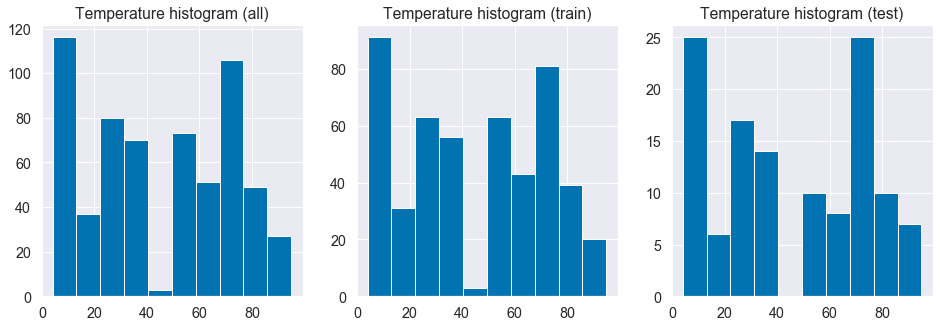

In [9]:
f, axes = plt.subplots(1, 3, figsize=(16, 5))
axes = axes.flatten()
balanced_metadata['temp'].hist(ax=axes[0]);
axes[0].set_title('Temperature histogram (all)')
balanced_metadata['temp'].iloc[train_idx].hist(ax=axes[1]);
axes[1].set_title('Temperature histogram (train)')
balanced_metadata['temp'].iloc[test_idx].hist(ax=axes[2]);
axes[2].set_title('Temperature histogram (test)');

## Evaluation

In [10]:
%%time
model.evaluate(x_test, y_test_norm, verbose=0)

CPU times: user 512 ms, sys: 54.3 ms, total: 567 ms
Wall time: 423 ms


1.4720230356591646

In [11]:
%%time
y_hat = model(x_test)
y_hat_mean = y_hat.mean().numpy().flatten()
y_mean = denormalize(y_hat_mean, mean, std)
y_std = denormalize(y_hat.stddev().numpy().flatten(), mean, std)

CPU times: user 370 ms, sys: 84.7 ms, total: 455 ms
Wall time: 300 ms


In [12]:
def plot_true_vs_prediction_scatter(metadata, y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    for i, tpl in enumerate(metadata.itertuples()):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    x_straight = range(0, 100)
    ax.plot(x_straight, x_straight, '--', color=palette[1], alpha=0.5)
    
    ax.set_xlabel('Temperature °C (true)')
    ax.set_ylabel('Temperature °C (prediction)')

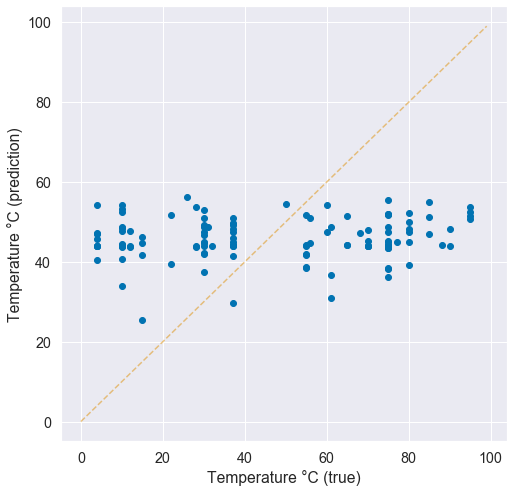

In [13]:
plot_true_vs_prediction_scatter(balanced_metadata.iloc[test_idx], y_test, y_mean)